<a href="https://colab.research.google.com/github/JohnAntonusMaximus/predicting-heart-disease/blob/master/Predicting_Heart_Disease_w_TensorFlow_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predicting Heart Disease w/ Machine Learning 

### Advances in artificial intelligence is allowing us to give better tooling to healthcare providers around the world, from predicting cancer, to analyzing human genome sequences. Using data from Cleveland Clinic, I wanted to try analyzing patient datasets on heart disease to see how machine learning could potentially help cardiologists. 

### Relevant Information:
     This database contains 76 attributes, but all published experiments
     refer to using a subset of 14 of them.  In particular, the Cleveland
     database is the only one that has been used by ML researchers to 
     this date.  The "goal" field refers to the presence of heart disease
     in the patient.  It is integer valued from 0 (no presence) to 4.
     Experiments with the Cleveland database have concentrated on simply
     attempting to distinguish presence (values 1,2,3,4) from absence (value
     0).  
   
     The names and social security numbers of the patients were recently 
     removed from the database, replaced with dummy values.


### Import All Dependencies

In [0]:
!pip install tensorflow-gpu==2.0.0.alpha

In [3]:
import sys
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from pandas.plotting import scatter_matrix

%matplotlib inline

tf.__version__
print("Python Version: {}".format(sys.version))
print("SKLearn Version: {}".format(sklearn.__version__))
print("Pandas Version: {}".format(pd.__version__))
print("Numpy Version: {}".format(np.__version__))

Python Version: 3.6.8 (default, Jan 14 2019, 11:02:34) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]
SKLearn Version: 0.21.3
Pandas Version: 0.24.2
Numpy Version: 1.16.4


## Import The Dataset From Cleveland Clinic

In [212]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

## Define Columns in Dataset

names = ['age',
        'sex',
        'cp',
        'trestbps',
        'chol',
        'fbs',
        'restecg',
        'thalach',
        'exang',
        'oldpeak',
        'slope',
        'ca',
        'thal',
        'class']

cleveland_data = pd.read_csv(url, names=names)

## Check the data
cleveland_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,class
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


### Here we have columns of various patient features, things like resting ECG, cholesterol, stress test results, and other relevant features for making a heart disease diagnosis

In [213]:
print(cleveland_data.shape)
print(cleveland_data.loc[1])

(303, 14)
age          67
sex           1
cp            4
trestbps    160
chol        286
fbs           0
restecg       2
thalach     108
exang         1
oldpeak     1.5
slope         2
ca          3.0
thal        3.0
class         2
Name: 1, dtype: object


# Data Cleaning

### Some of the data has missing or null values which will be useless in training a neural network, we need to do some data cleaning before we pass them into a neural network.

In [0]:
## Remove missing data
data = cleveland_data[-cleveland_data.isin(['?'])]

In [215]:
data.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,class
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,NaN,3.0,0


In [218]:
## Drop rows with NaN 
data = data.dropna(axis=0)
data.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,class
297,57.0,0.0,4.0,140.0,241.0,0.0,0.0,123.0,1.0,0.2,2.0,0.0,7.0,1
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1


### All null values are dropped, leaving us with about 300 usefull patient records with complete information.

In [219]:
data.isnull().sum(axis = 0)

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
class       0
dtype: int64

In [220]:
print(data.shape)
print(data.dtypes)

(297, 14)
age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca           object
thal         object
class         int64
dtype: object


### Our data types need to be changed to numerics before we pass them in, some more pre-processing...

In [221]:
data = data.apply(pd.to_numeric)
print(data.dtypes)

age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca          float64
thal        float64
class         int64
dtype: object


### Show the Data Distributions

### Now that our dataset is a little cleaner, we can view the distributions and see our dataset is skewed, has outliers, and how it may affect a predictive model.

In [222]:
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,class
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,3.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,1.602694,0.676768,4.730640,0.946128
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,0.938965,1.938629,1.234551
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


### Because the scale of our data has wide minimums and maximums, it may make sense for us to normalize our data (Scale all of our non-binary values to between 0 and 1 )

In [223]:
cols_to_norm = ['age', 'trestbps','chol', 'thalach', 'thal']

data_normalized = data[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

## Add back in our other columns

data_normalized['sex'] = data['sex']
data_normalized['cp'] = data['cp']
data_normalized['fbs'] = data['fbs']
data_normalized['restecg'] = data['restecg']
data_normalized['exang'] = data['exang']
data_normalized['oldpeak'] = data['oldpeak']
data_normalized['slope'] = data['slope']
data_normalized['ca'] = data['ca']
data_normalized['class'] = data['class']
data_normalized

,age,trestbps,chol,thalach,thal,sex,cp,fbs,restecg,exang,oldpeak,slope,ca,class
0,0.708333,0.481132,0.244292,0.603053,0.75,1.0,1.0,1.0,2.0,0.0,2.3,3.0,0.0,0
1,0.791667,0.622642,0.365297,0.282443,0.00,1.0,4.0,0.0,2.0,1.0,1.5,2.0,3.0,2
2,0.791667,0.245283,0.235160,0.442748,1.00,1.0,4.0,0.0,2.0,1.0,2.6,2.0,2.0,1
3,0.166667,0.339623,0.283105,0.885496,0.00,1.0,3.0,0.0,0.0,0.0,3.5,3.0,0.0,0
4,0.250000,0.339623,0.178082,0.770992,0.00,0.0,2.0,0.0,2.0,0.0,1.4,1.0,0.0,0
5,0.562500,0.245283,0.251142,0.816794,0.00,1.0,2.0,0.0,0.0,0.0,0.8,1.0,0.0,0
6,0.687500,0.433962,0.324201,0.679389,0.00,0.0,4.0,0.0,2.0,0.0,3.6,3.0,2.0,3
7,0.583333,0.245283,0.520548,0.702290,0.00,0.0,4.0,0.0,0.0,1.0,0.6,1.0,0.0,0
8,0.708333,0.339623,0.292237,0.580153,1.00,1.0,4.0,0.0,2.0,0.0,1.4,2.0,1.0,2
9,0.500000,0.433962,0.175799,0.641221,1.00,1.0,4.0,1.0,2.0,1.0,3.1,3.0,0.0,1


### Now our data is much more uniform but stil represents the results of individual patients

In [0]:
data = data_normalized

## Distribution Visualizations

#### The dataset is about 300 patients, roughly equally split between patients with heart disease and patients without heart disease. The 'class' column describes the severity of heart disease with class "4" being the most severe. The data distribution reflects the rarity of this type of heart disease.

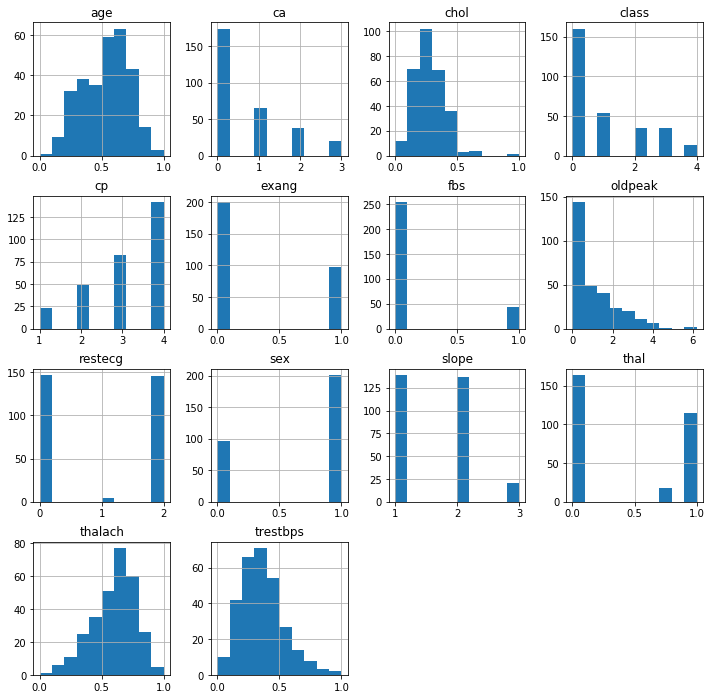

In [225]:
data.hist(figsize=(12,12))
plt.show()

In [0]:
from sklearn import model_selection

X = np.array(data.drop(['class'], axis=1))
y = np.array(data['class'])

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y, test_size=0.2)

In [227]:
y_test[:5]

array([0, 4, 0, 0, 0])

### Change the labels to categoral labels

In [0]:
from keras.utils.np_utils import to_categorical

In [229]:
Y_train = to_categorical(y_train,num_classes=None)
Y_test = to_categorical(y_test, num_classes=None)

print(Y_train.shape)
print(Y_test.shape)
print(X_train.shape)

X_train[1]

(237, 5)
(60, 5)
(237, 13)


array([0.6875    , 0.43396226, 0.32420091, 0.67938931, 0.        ,
       0.        , 4.        , 0.        , 2.        , 0.        ,
       3.6       , 3.        , 2.        ])

## Define The Neural Network Mode

In [0]:
def create_model():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(units=128, activation="relu", input_shape=(13,)))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=64, activation="relu"))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=32, activation="relu")) 
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=5, activation="softmax"))
  
  model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.0001), metrics=["categorical_accuracy"])
  
  return model


## Here's our neural network

In [231]:
model = create_model()
print(model.summary())

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_82 (Dense)             (None, 128)               1792      
_________________________________________________________________
dropout_61 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_83 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_62 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_84 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_63 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_85 (Dense)             (None, 5)               

## Let's train the model on the patient data

In [232]:
model.fit(X_train, Y_train, epochs=300, batch_size=10, verbose=True)

Epoch 1/300
237/237 [==============================] - 0s 878us/sample - loss: 1.5828 - categorical_accuracy: 0.2616
Epoch 2/300
237/237 [==============================] - 0s 163us/sample - loss: 1.5380 - categorical_accuracy: 0.3460
Epoch 3/300
237/237 [==============================] - 0s 171us/sample - loss: 1.5226 - categorical_accuracy: 0.3333
Epoch 4/300
237/237 [==============================] - 0s 175us/sample - loss: 1.5116 - categorical_accuracy: 0.3966
Epoch 5/300
237/237 [==============================] - 0s 171us/sample - loss: 1.4891 - categorical_accuracy: 0.4346
Epoch 6/300
237/237 [==============================] - 0s 203us/sample - loss: 1.4418 - categorical_accuracy: 0.4726
Epoch 7/300
237/237 [==============================] - 0s 193us/sample - loss: 1.4565 - categorical_accuracy: 0.4810
Epoch 8/300
237/237 [==============================] - 0s 185us/sample - loss: 1.4204 - categorical_accuracy: 0.5148
Epoch 9/300
237/237 [==============================] - 0s 186us/

## About 70% accuracy on the training data for predicting the type of heart disease...whomp whomp...

#Results

###Due to the size of our dataset and the limited amount of featuers we're using, our machine learning model is definitely better than a random guess, however as a diagnostic tool, its far from state of the art at 70%. This may be because we need more features included in our dataset to accurately diagnore the type of heart disease, but also may be related to the fact that our dataset is quite small (only 300 patients)

### Let's see what happens if we convert this to a binary classification problem...in other words, rather than trying to predict the specific type of heart disease a patient may have, we switch the prediction to "Does the patient have heart disease: yes or no?"

#### Make a copy of the dataset

In [0]:
Y_test_binary = y_test.copy()

In [0]:
Y_train_binary = y_train.copy()

#### We need to change our training and tests labels to just 0's or 1's...0 a patient does not have heart disease, 1 a patient does have heart disease.

In [0]:
Y_train_binary[Y_train_binary > 0] = 1

In [0]:
Y_test_binary[Y_test_binary > 0] = 1

In [237]:
print(Y_test_binary[:20])

[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0]


### Build a binary classification model. Here I'm using almost the same neural network architecture, but the output layer changes to only a single neuron with a sigmoid activation function for binary classification.

In [0]:
def create_binary_model():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(units=128, activation="relu", input_shape=(13,)))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(units=64, activation="relu"))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(units=32, activation="relu")) 
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(units=16, activation="relu")) 
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(units=8, activation="relu")) 
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))
  
  model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(0.001), metrics=["accuracy"])
  
  return model

### Build and summarize the model

In [239]:
model_binary = create_binary_model()
print(model_binary.summary())

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_86 (Dense)             (None, 128)               1792      
_________________________________________________________________
dropout_64 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_87 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_65 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_88 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_66 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_89 (Dense)             (None, 16)              

### Training our new model, accuracy is definitely better!

In [240]:
model_binary.fit(X_train, Y_train_binary, epochs=300, batch_size=10, verbose=1)

Epoch 1/300
237/237 [==============================] - 0s 1ms/sample - loss: 0.7858 - accuracy: 0.4641
Epoch 2/300
237/237 [==============================] - 0s 184us/sample - loss: 0.7606 - accuracy: 0.4219
Epoch 3/300
237/237 [==============================] - 0s 184us/sample - loss: 0.7281 - accuracy: 0.4895
Epoch 4/300
237/237 [==============================] - 0s 180us/sample - loss: 0.7252 - accuracy: 0.4557
Epoch 5/300
237/237 [==============================] - 0s 194us/sample - loss: 0.7078 - accuracy: 0.4979
Epoch 6/300
237/237 [==============================] - 0s 204us/sample - loss: 0.7140 - accuracy: 0.4430
Epoch 7/300
237/237 [==============================] - 0s 205us/sample - loss: 0.7033 - accuracy: 0.4810
Epoch 8/300
237/237 [==============================] - 0s 190us/sample - loss: 0.7075 - accuracy: 0.4430
Epoch 9/300
237/237 [==============================] - 0s 258us/sample - loss: 0.7072 - accuracy: 0.4937
Epoch 10/300
237/237 [==============================] - 0

#### Training accuracy approaches 100%, however when we run the model on our test set, we only get 77% accuracy, which suggest we have some overfitting to our training set, most likely because our patient dataset is very small as well.


In [241]:
test_loss, test_accuracy = model_binary.evaluate(X_test, Y_test_binary)
print("Test Patient Accuracy: {}".format(test_accuracy))


60/60 [==============================] - 0s 2ms/sample - loss: 1.4566 - accuracy: 0.7667
Test Patient Accuracy: 0.7666666507720947


## Analyzing Results: Precision, Recall, and F1 Scores

### State of the art machine learning models typically have F1 scores in the greater than 90% range. F1 Score is in the weighted average between our precision (measure of number of false postives) and Recall (measure of the number of false negatives, which for heart disease is more dangerous). 

In [242]:
from sklearn.metrics import classification_report, accuracy_score

categorical_pred = np.argmax(model.predict(X_test), axis=1)

print("Result for Categorical Model: ")
print(accuracy_score(y_test, categorical_pred))
print(classification_report(y_test, categorical_pred))

Result for Categorical Model: 
0.6333333333333333
              precision    recall  f1-score   support

           0       0.83      0.92      0.88        38
           1       0.17      0.12      0.14         8
           2       0.25      0.33      0.29         6
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         2

    accuracy                           0.63        60
   macro avg       0.25      0.28      0.26        60
weighted avg       0.57      0.63      0.60        60



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 60% on an F1-Score, not very good for predicting what type of heart disease a patient has.

### Our F1 Score however is much better when converted to a binary classification problem, 76%, (Does the patient have heart disease?), however its still far from being a completely reliable diagnosing tool given our dataset. We'd need to do some more feature engineering and data collection to train this model better. 

In [243]:
# Preccsion tracks false positives, Recall tracks false negatives

binary_pred = np.round(model_binary.predict(X_test)).astype(int)

print("Result for Binary Model: ")
print(accuracy_score(Y_test_binary, binary_pred))
print(classification_report(Y_test_binary, binary_pred))

Result for Binary Model: 
0.7666666666666667
              precision    recall  f1-score   support

           0       0.80      0.84      0.82        38
           1       0.70      0.64      0.67        22

    accuracy                           0.77        60
   macro avg       0.75      0.74      0.74        60
weighted avg       0.76      0.77      0.76        60



### A cardiologist could use this model right now as a pointer towards a probability of a patient having heart disease, however it shouldn't be used as the end-all-be-all of a diagnosis. We'd need more patient data and more features to make it more accurate.